<center> <img src = https://deveducation.com/wp-content/uploads/2022/05/e02645f9-693d-40de-a13f-c60cbbdf273e.webp alt="drawing" style="width:400px;">

# <center> PROJECT-3. EDA + Feature Engineering. Соревнование на Kaggle

In [62]:
# Импортируем необходимые библиотеки

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from geopy.geocoders import Nominatim
from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 

0. Предварительное знакомство с данными.


In [63]:
hotels = pd.read_csv('Data/hotels.csv')
display(hotels.head(3))

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [64]:
display(hotels.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

None

In [65]:
hotels.isna().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
reviewer_score                                   0
tags                                             0
days_since_review                                0
lat                                           2448
lng                                           2448
dtype: int64

1. Очистка данных от пропущенных значений.

In [66]:
# Очистка пропусков в координатах на основе использования библиотеки geopy

# Создаем список отелей, для которых пропущены координаты
missing_data = hotels[hotels['lat'].isna() | hotels['lng'].isna()]
missing_list = list(missing_data['hotel_name'].unique())

# Создаем объект геокодера
geolocator = Nominatim(user_agent="geoapiUseragent")

# Словарь для пропущенных значений
hotel_coordinates = {}

for hotel_name in missing_list:
    except_ = True
    i = 4
    while except_:
        try:
            except_ = False
            short_hotel_name = hotel_name.split(' ')[:i]
            short_hotel_name = " ".join(short_hotel_name)
            location = geolocator.geocode(short_hotel_name)
            hotel_coordinates[hotel_name] = [location.latitude, location.longitude]
        except:
            print('Except')
            print(short_hotel_name)
            i -= 1
            except_ = True
        
display(hotel_coordinates)

def get_coord(row):
    if pd.isna(row.lat):
        row.lat = hotel_coordinates[row.hotel_name][0]
        row.lng = hotel_coordinates[row.hotel_name][1]
        return row
    else: 
        return row

hotels = hotels.apply(lambda row: get_coord(row), axis=1)

Except
Derag Livinghotel Kaiser Franz
Except
Derag Livinghotel Kaiser
Except
City Hotel Deutschmeister
Except
City Hotel Deutschmeister
Except
Hotel Pension Baron am
Except
Hotel Pension Baron
Except
Mercure Paris Gare Montparnasse


{'Austria Trend Hotel Schloss Wilhelminenberg Wien': [48.2196753, 16.2854959],
 'Holiday Inn Paris Montmartre': [48.8716034, 2.3435792],
 'Fleming s Selection Hotel Wien City': [50.11753335, 8.680225139617644],
 'Hotel Atlanta': [50.8520697, 4.354408380443903],
 'Maison Albar Hotel Paris Op ra Diamond': [48.8753905, 2.2944392],
 'Derag Livinghotel Kaiser Franz Joseph Vienna': [48.1344161, 11.5759387],
 'Hotel City Central': [48.2135658, 16.3799212],
 'NH Collection Barcelona Podium': [41.39188235, 2.1779639552623635],
 'City Hotel Deutschmeister': [41.321954700000006, 19.81620757120013],
 'Hotel Daniel Vienna': [48.1888627, 16.3838516356697],
 'Roomz Vienna': [48.222974, 16.393313],
 'Hotel Pension Baron am Schottentor': [50.8401575, 11.4023074],
 'Mercure Paris Gare Montparnasse': [48.8760449, 2.3557305],
 'Hotel Park Villa': [49.13646555, 9.230946491810585],
 'Hotel Advance': [27.6848475, 85.3295141],
 'Renaissance Barcelona Hotel': [41.3927154, 2.1674921],
 'Cordial Theaterhotel Wie

In [67]:
hotels.isna().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
reviewer_score                                0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
dtype: int64

2. Создание новых признаков.

In [68]:
# 2.1 Признак город расположения отеля.

def get_city(arg):
    """Функция извлечения названия города из признака адреса отеля

    Args:
        arg (object): Адрес отеля

    Returns:
        string: Город расположения отеля
    """
    city = arg.split(' ')[-2]
    
    if (city == 'United'):
        city = arg.split(' ')[-5]
        return city

    return city
    
hotels['city'] = hotels['hotel_address'].apply(get_city)
display(hotels['city'].value_counts())
hotels = hotels.drop('hotel_address', axis=1)
display(hotels.head(3))

London       196774
Barcelona     45132
Paris         44830
Amsterdam     43006
Vienna        29178
Milan         27883
Name: city, dtype: int64

,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,city
0,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,London
1,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,London
2,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,Paris


In [69]:
# Задание 2.2 Признак суммарное количество отелей в городе.

table = hotels.groupby(['city'])['hotel_name'].unique()
hotels['total_hotels_counts'] = hotels['city'].apply(lambda x: len(table[x]))
hotels = hotels.drop('hotel_name', axis=1)
hotels.head(3)

,additional_number_of_scoring,review_date,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,city,total_hotels_counts
0,581,2/19/2016,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,London,400
1,299,1/12/2017,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,London,400
2,32,10/18/2016,8.9,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,Paris,458


In [70]:
#2.3 Признак сезонности на основе даты.

hotels['review_date'] = pd.to_datetime(hotels['review_date'])

def get_season(dt):
    """Функция получения сезона в зависимости от месяца

    Args:
        arg (object): Дата оставления отзыва

    Returns:
        string: Название сезона
    """
    if dt.month in [12, 1, 2]:
        return "Winter"
    elif dt.month in [3, 4, 5]:
        return "Spring"
    elif dt.month in [6, 7, 8]:
        return "Summer"
    else:
        return "Fall"

hotels['season'] = hotels['review_date'].apply(get_season)

hotels = hotels.drop('review_date', axis=1)
display(hotels.head(3))

,additional_number_of_scoring,average_score,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,city,total_hotels_counts,season
0,581,8.4,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,London,400,Winter
1,299,8.3,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,London,400,Winter
2,32,8.9,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,Paris,458,Fall


In [71]:
# Задание 2.4 Признак национальность ревьюера.

display(hotels['reviewer_nationality'].value_counts())

hotels['reviewer_nationality_UK'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x.strip() == 'United Kingdom' else 0)
hotels['reviewer_nationality_USA'] = hotels['reviewer_nationality'].apply(lambda x: 1 if x.strip() == 'United States of America' else 0)

hotels = hotels.drop('reviewer_nationality', axis=1)
hotels.head(3)

 United Kingdom               184033
 United States of America      26541
 Australia                     16239
 Ireland                       11126
 United Arab Emirates           7617
                               ...  
 Cook Islands                      1
 Guinea                            1
 Comoros                           1
 Anguilla                          1
 Grenada                           1
Name: reviewer_nationality, Length: 225, dtype: int64

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,city,total_hotels_counts,season,reviewer_nationality_UK,reviewer_nationality_USA
0,581,8.4,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,London,400,Winter,1,0
1,299,8.3,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,London,400,Winter,1,0
2,32,8.9,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,Paris,458,Fall,0,0


In [72]:
# 2.5 Признаки на основе тегов.

def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags'] = hotels['tags'].apply(rev_func)
    
hotels['Leisure trip'] = hotels['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
hotels['Submitted from a mobile device'] = hotels['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)
hotels['Couple'] = hotels['tags'].apply(lambda x: 1 if 'Couple' in x else 0)

hotels = hotels.drop('tags', axis=1)
display(hotels.head(3))

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,city,total_hotels_counts,season,reviewer_nationality_UK,reviewer_nationality_USA,Leisure trip,Submitted from a mobile device,Couple
0,581,8.4,Leaving,3,1994,Staff were amazing,4,7,10.0,531 day,51.507894,-0.143671,London,400,Winter,1,0,1,1,1
1,299,8.3,poor breakfast,3,1361,location,2,14,6.3,203 day,51.521009,-0.123097,London,400,Winter,1,0,0,0,1
2,32,8.9,No kettle in room,6,406,No Positive,0,14,7.5,289 day,48.845377,2.325643,Paris,458,Fall,0,0,1,1,0


In [73]:
# 2.6 Преобразование признака количество дней прошедшее с даты ревью

def get_days(arg):
    """Функция преобразования признака количества дней прошедшее с даты ревью

    Args:
        arg (object): Количество дней в текстовом формате

    Returns:
        int: Количество дней
    """

    days = arg.split(' ')[0]

    return int(days)

hotels['days_since_review'] = hotels['days_since_review'].apply(get_days)

display(hotels.head(3))

,additional_number_of_scoring,average_score,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,city,total_hotels_counts,season,reviewer_nationality_UK,reviewer_nationality_USA,Leisure trip,Submitted from a mobile device,Couple
0,581,8.4,Leaving,3,1994,Staff were amazing,4,7,10.0,531,51.507894,-0.143671,London,400,Winter,1,0,1,1,1
1,299,8.3,poor breakfast,3,1361,location,2,14,6.3,203,51.521009,-0.123097,London,400,Winter,1,0,0,0,1
2,32,8.9,No kettle in room,6,406,No Positive,0,14,7.5,289,48.845377,2.325643,Paris,458,Fall,0,0,1,1,0


3. Кодирование категориальных признаков.

In [74]:
#Кодирование номинальных категориальных признаков. Признаки: название города, сезонность. Используем метод get_dummies().

hotels = pd.get_dummies(hotels, columns=['city', 'season'])

hotels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   negative_review                             386803 non-null  object 
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   positive_review                             386803 non-null  object 
 6   review_total_positive_word_counts           386803 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 8   reviewer_score                              386803 non-null  float64
 9   days_since_review                           386803 non-null  int64  
 

4. Анализ текстовых отзывов.

In [75]:
nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

hotels['negative_review_neg'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['neg'])
hotels['negative_review_compound'] = hotels['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels['positive_review_pos'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['pos'])
hotels['positive_review_compound'] = hotels['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x)['compound'])

hotels.info()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   negative_review                             386803 non-null  object 
 3   review_total_negative_word_counts           386803 non-null  int64  
 4   total_number_of_reviews                     386803 non-null  int64  
 5   positive_review                             386803 non-null  object 
 6   review_total_positive_word_counts           386803 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 8   reviewer_score                              386803 non-null  float64
 9   days_since_review                           386803 non-null  int64  
 

In [76]:
hotels = hotels.drop('negative_review', axis=1)
hotels = hotels.drop('positive_review', axis=1)
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 30 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int64  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

5. Анализ мультиколлинеарности.

<AxesSubplot:>

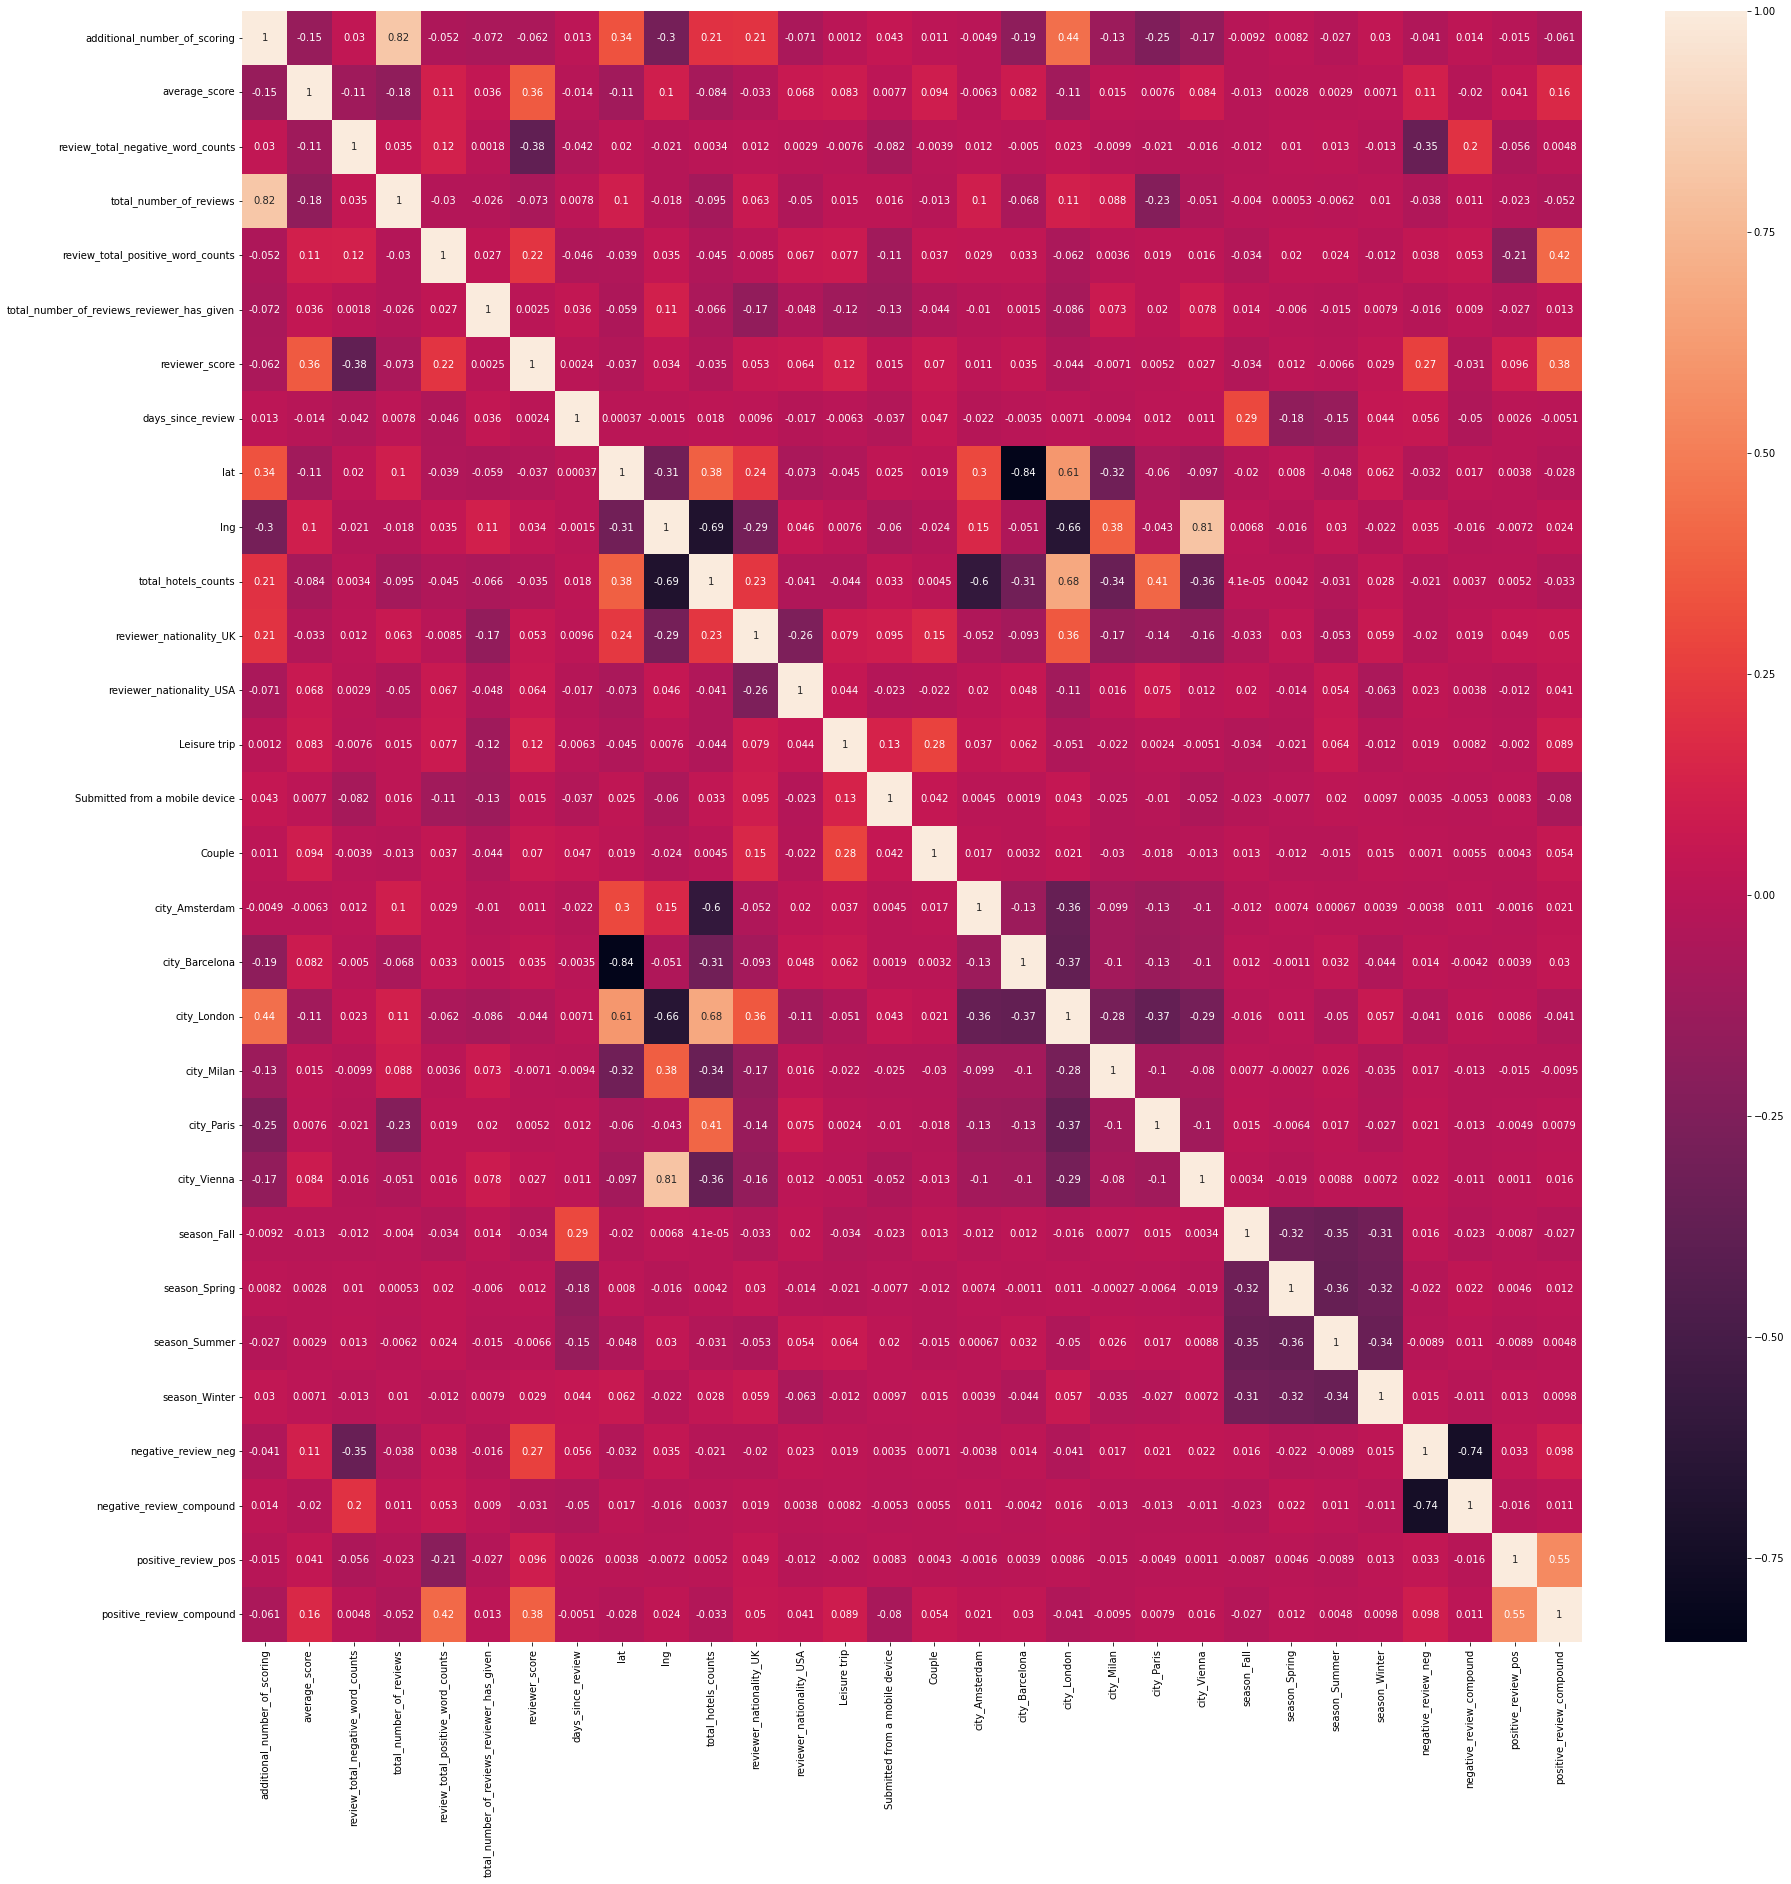

In [77]:
#Анализ мультиколлинеарности числовых признаков. Если признаки имеют коэффициент корреляции >+/- 0.95. то один из признаков удаляем.

fig = plt.figure(figsize=(30,30))
sns.heatmap(hotels.corr(method='pearson'), annot=True)

6. Отбор признаков на основе их важности.

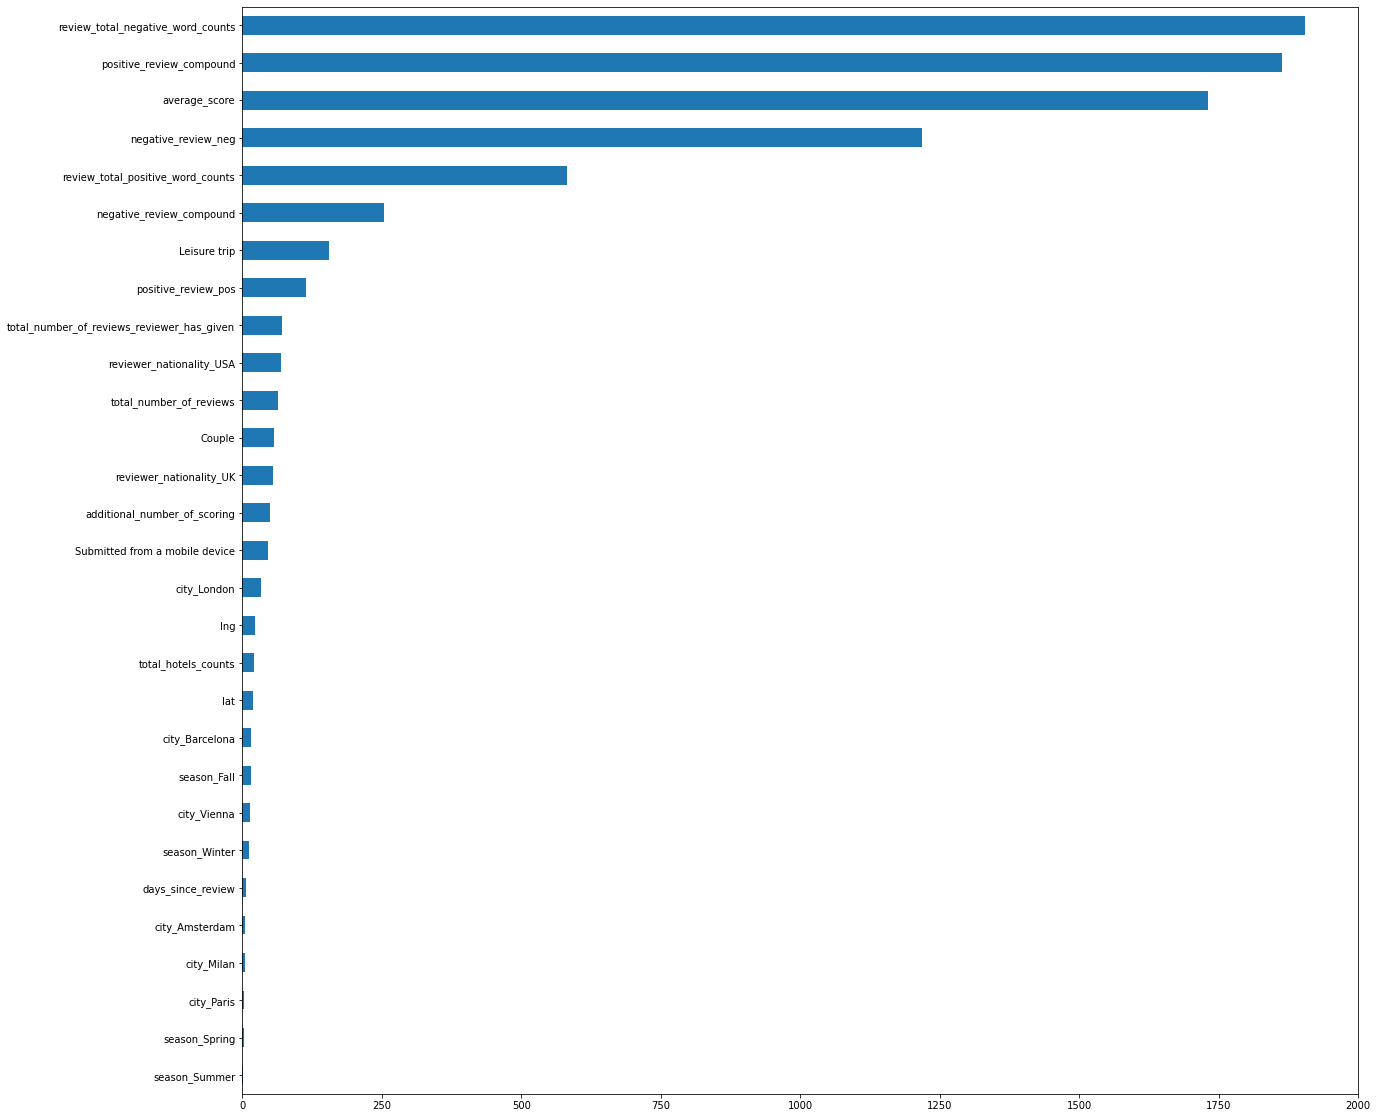

In [78]:
# Проводим тест ANOVA
# Оставляем только 15-20 признаков, которые имеют наибольшее значение.

 # Х — данные с информацией об отелях, у — целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score']

fig = plt.figure(figsize=(20,20))
imp_num = pd.Series(f_classif(X, y)[0], index = X.columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

X = X.drop(columns=['season_Summer', 'season_Spring','city_Paris', 'city_Milan', 'city_Amsterdam', 'days_since_review',
                   'season_Winter', 'city_Vienna', 'city_Barcelona', 'season_Fall'], axis=1)

In [79]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   lat                                         386803 non-null  float64
 7   lng                                         386803 non-null  float64
 8   total_hotels_counts                         386803 non-null  int64  
 9   reviewer_nationality_UK                     386803 non-null  int64  
 

7. Нормализация данных.

In [80]:
#7.1 Использование масштабирования данных на основе MinMaxScaler (опционально).
#7.2 Использование стандартизации данных на основе StandardScaler (опционально).

8. Реализация машинного алгоритма и проверка его эффективности. MAPE должен быть менее 13.5%

In [81]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" — для тестирования.  
    # Для тестирования мы будем использовать 25 % от исходного датасета.  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [82]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test) и смотрим, насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений в отношении фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1258201029315806


# Выводы

В результате работы над данным проектом:
-  Cоздана первая модель, основаннованная на алгоритмах машинного обучения
-  Принято участие в соревновании на Kaggle
-  В результате выполнения правильной подготовки данных точность модели повысилась с 14.1% до 12.5% MAPE.